# 0. Import library


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import warnings
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

# 1. Load Data

In [2]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/"

In [5]:
# 데이터 불러오기
train_df = pd.read_csv(path+"train.csv")

In [6]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(train_df.values):
    image=cv2.imread(path+"mask_train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)


100%|██████████| 7095/7095 [1:08:11<00:00,  1.73it/s]


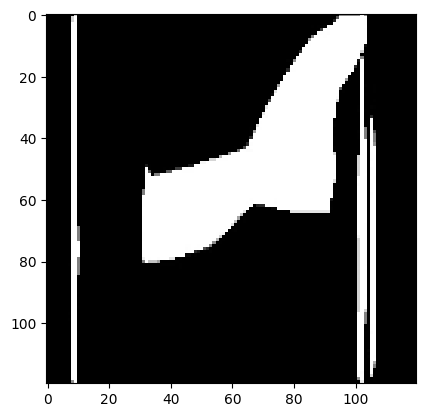

In [7]:
plt.imshow(l1[16])

Label encoding the input features and one hot encoding the target feature.

In [8]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

Splitting the data into 80% train set and 20% test set

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [10]:
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


# 3. CNN


[참고 자료](https://www.kaggle.com/code/ratul6/steel-defect-detection-using-cnn) <br>

Building the CNN Model

In [11]:
img_shape = (120,120,3)

# Set up the model
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3), strides=(1, 1), padding="same", activation="relu",input_shape=img_shape))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Compiling the model

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

Fitting the model

In [14]:
history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1, callbacks=[early_stopping])

Epoch 1/15
45/45 [==============================] - 14s 100ms/step - loss: 0.8738 - accuracy: 0.7146 - val_loss: 0.7884 - val_accuracy: 0.7259
Epoch 2/15
45/45 [==============================] - 2s 52ms/step - loss: 0.7445 - accuracy: 0.7259 - val_loss: 0.6763 - val_accuracy: 0.7252
Epoch 3/15
45/45 [==============================] - 2s 49ms/step - loss: 0.6215 - accuracy: 0.7401 - val_loss: 0.6069 - val_accuracy: 0.7562
Epoch 4/15
45/45 [==============================] - 2s 48ms/step - loss: 0.5723 - accuracy: 0.7521 - val_loss: 0.5639 - val_accuracy: 0.7512
Epoch 5/15
45/45 [==============================] - 2s 49ms/step - loss: 0.5360 - accuracy: 0.7644 - val_loss: 0.5268 - val_accuracy: 0.7689
Epoch 6/15
45/45 [==============================] - 2s 51ms/step - loss: 0.5132 - accuracy: 0.7717 - val_loss: 0.5166 - val_accuracy: 0.7653
Epoch 7/15
45/45 [==============================] - 3s 56ms/step - loss: 0.4892 - accuracy: 0.7812 - val_loss: 0.5024 - val_accuracy: 0.7696
Epoch 8/15


<Axes: title={'center': 'Loss curve'}>

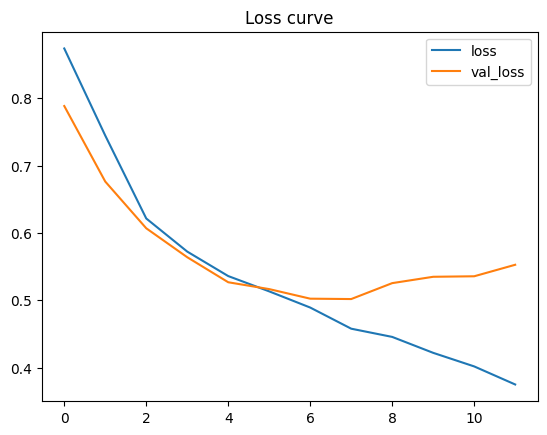

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

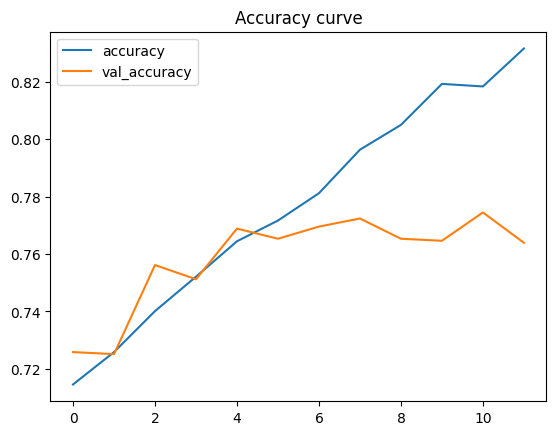

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [17]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

45/45 [==============================] - 1s 8ms/step - loss: 0.5024 - accuracy: 0.7696
[+] Accuracy: 76.96%
